In [1]:
import matplotlib.pyplot as plt
import pickle
import os
import sys
import json
import torchsort
import argparse
import gc
import tqdm
import numpy as np
import scipy
import seaborn as sb 
%matplotlib inline
 
from sklearn.preprocessing import LabelEncoder
import pandas as pd
vx = pd.read_parquet('//home//a//Documents//nmr_classic//v4.3//737_v4.3_validation_int8.parquet') #391_v4_validation_int8.parquet')
dataset = pd.read_parquet('//home//a//Documents//nmr_classic//v4.3//658_v4.3_train_int8.parquet') #391_v4_train_int8.parquet')
with open("//home//a//Documents//nmr_classic//v4.3//features.json", "r") as f:feature_metadata = json.load(f)
features = feature_metadata["feature_sets"]["small"] 
dataset = pd.concat([dataset[list(features)+['era', 'data_type', 'target']], vx[list(features)+['era', 'data_type','target']]])
dataset.drop(dataset[dataset['data_type'] == 'test'].index, inplace = True)
vx = dataset.loc[dataset.era.isin(dataset.era.unique()[-100:])]
dataset = dataset.loc[~dataset.era.isin(dataset.era.unique()[-100:])]
gc.collect()


/home/a/miniconda3/envs/tch3_clone/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0

In [2]:
def upper(df):
    '''Returns the upper triangle of a correlation matrix.
    You can use scipy.spatial.distance.squareform to recreate matrix from upper triangle.
    Args:
      df: pandas or numpy correlation matrix
    Returns:
      list of values from upper triangle
    '''
    try:
        assert(type(df)==np.ndarray)
    except:
        if type(df)==pd.DataFrame:
            df = df.values
        else:
            raise TypeError('Must be np.ndarray or pd.DataFrame')
    mask = np.triu_indices(df.shape[0], k=1)
    return df[mask]


In [3]:
    
corr_mat_tr = {}
psd_mat_data = []
for ii, era in tqdm.tqdm(enumerate(dataset.era.unique())):
    corr_matrix_vector = upper(np.corrcoef((np.float32(dataset.loc[dataset.era == era, features])-.2).T))
    corr_mat_tr[era] = corr_matrix_vector
corr_mat_vx = {}
psd_mat_data_vx = []
for ii, era in tqdm.tqdm(enumerate(vx.era.unique())):
    corr_matrix_vector = upper(np.corrcoef((np.float32(vx.loc[vx.era == era, features])-.2).T))
    corr_mat_vx[era] = corr_matrix_vector


0it [00:00, ?it/s]/home/a/miniconda3/envs/tch3_clone/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/a/miniconda3/envs/tch3_clone/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
1it [00:00,  4.41it/s]/home/a/miniconda3/envs/tch3_clone/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/a/miniconda3/envs/tch3_clone/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
2it [00:00,  4.40it/s]/home/a/miniconda3/envs/tch3_clone/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/a/miniconda3/envs/tch3_clone/lib/python3.10/site-packages/numpy/lib/func

In [4]:
for key, value in corr_mat_tr.items():
    if np.isnan(value).any():  # Check if there are any NaN values
        corr_mat_tr[key] = np.nan_to_num(value)  # Replace NaNs with zeros


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.5s remaining:    1.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished


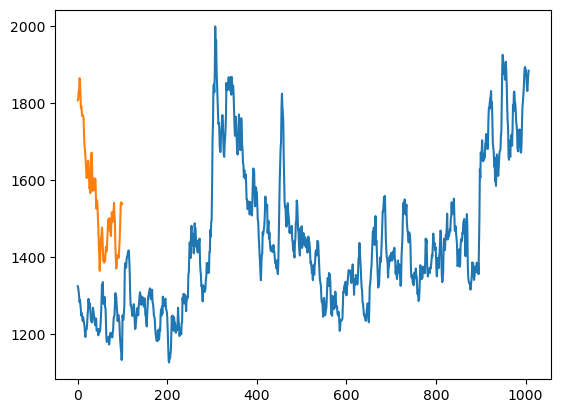

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished


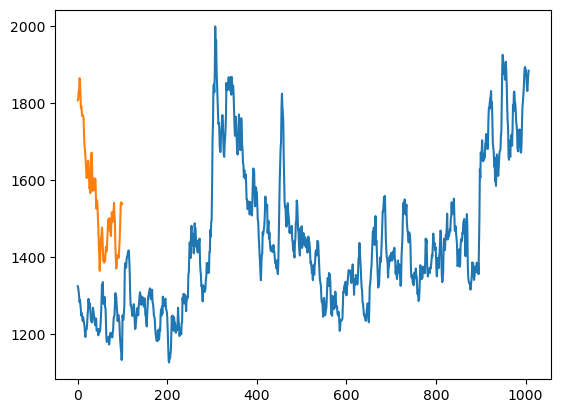

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished


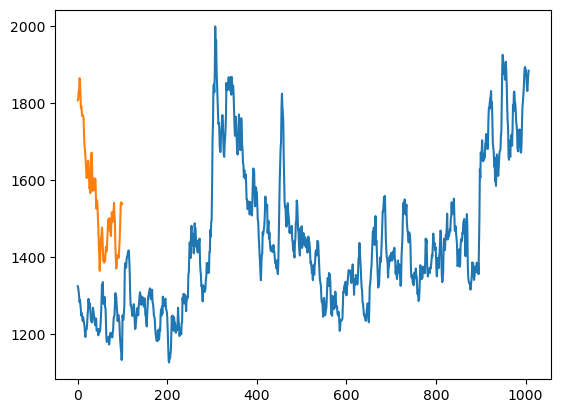

In [5]:
from pyod.models.ecod import ECOD
clf = ECOD(n_jobs=4)
eras_data = {}
for i in [1, 4, 7]:
    eras = list(corr_mat_tr.keys())
    clf.fit(np.vstack([corr_mat_tr.get(key) for key in eras]))
    eras_data[i] = {}
    eras_data[i]['tr_eras'] =  eras
    y_train_scores = clf.decision_scores_  # raw outlier scores on the train data
    y_test_scores = clf.decision_function(np.vstack([corr_mat_vx.get(key) for key in list(corr_mat_vx)]))  # predict raw outlier scores on test
    eras_data[i]['tr_scores'] = y_train_scores
    eras_data[i]['vx_eras'] = list(corr_mat_vx)

    eras_data[i]['vx_scores'] = y_test_scores
    plt.figure()
    plt.plot(y_train_scores)
    plt.plot(y_test_scores)
    plt.show()
